# REINFORCE in TensorFlow (3 pts)¶

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

env: THEANO_FLAGS='floatX=float32'


The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


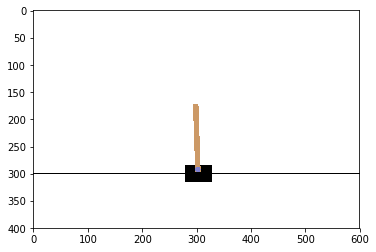

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [3]:
import tensorflow as tf

#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', [None, state_dim[0]], name="states")
actions = tf.placeholder('int32', [None], name="action_ids")
cumulative_rewards = tf.placeholder('float32', [None], name="cumulative_returns")

In [4]:
def build_mlp(
        input_placeholder,
        output_size,
        n_layers=2,
        size=64,
        activation=tf.tanh,
        output_activation=None
        ):

    output = input_placeholder
    for i in range(n_layers):
        output = tf.layers.dense(output, size, activation=activation,
                use_bias=True, kernel_initializer=tf.orthogonal_initializer,
                name="dense_{}".format(i))
    output = tf.layers.dense(output, output_size, activation=output_activation,
            use_bias=True, kernel_initializer=tf.orthogonal_initializer,
            name="dense_{}".format(n_layers))

    return output

# Construct model
logits = build_mlp(states, n_actions)
policy = tf.nn.softmax(logits)
negative_likelihoods = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=actions, logits=logits)
weighted_negative_likelihoods = tf.multiply(negative_likelihoods, cumulative_rewards)
loss = tf.reduce_mean(weighted_negative_likelihoods)

In [5]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [6]:
update = tf.train.AdamOptimizer(5e-3).minimize(loss)

### Computing cumulative rewards

In [7]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 1.0 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cum_rewards = np.zeros_like(rewards, dtype=np.float32)
    for i in range(len(cum_rewards)):
        G = 0
        for j in range(i, len(rewards)):
            G += np.power(gamma, j-i) * rewards[j]
        cum_rewards[i] = G
        
    return cum_rewards

In [8]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),
                   [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), 
                   [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), 
                   [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [9]:
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})

### Playing the game

In [10]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        a = np.random.choice(n_actions, 1, p=action_probas)[0]
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states,actions,rewards)
            
    return sum(rewards)

In [11]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:55.200
mean reward:82.460
mean reward:82.980
mean reward:59.450
mean reward:40.620
mean reward:19.290
mean reward:9.800
mean reward:12.090
mean reward:27.190
mean reward:29.110
mean reward:28.540
mean reward:29.710
mean reward:35.840
mean reward:99.680
mean reward:143.620
mean reward:954.010
You Win!


### Results & video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [12]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'gmail.com', 'token')

Submitted to Coursera platform. See results on assignment page!


In [ ]:
#That's all, thank you for your attention!